## PyTorch practice, hints and Dataloaders

Credits:
* First part is based on YSDA [Practical RL course week04 materials](https://github.com/yandexdataschool/Practical_RL/tree/master/week04_%5Brecap%5D_deep_learning).
* Second part is based on PyTorch official tutorials and [this kaggle kernel](https://www.kaggle.com/pinocookie/pytorch-dataset-and-dataloader)
* Third part is based on PyTorch tutorial by [Stanford CS 231n course](http://cs231n.stanford.edu)

![img](https://pytorch.org/tutorials/_static/pytorch-logo-dark.svg)

__This notebook__ will remind you how to use pytorch low and high-level core. You can install it [here](http://pytorch.org/).

__Pytorch feels__ differently than other frameworks (like tensorflow/theano) on almost every level. TensorFlow makes your code live in two "worlds" simultaneously:  symbolic graphs and actual tensors. First you declare a symbolic "recipe" of how to get from inputs to outputs, then feed it with actual minibatches of data.  In pytorch, __there's only one world__: all tensors have a numeric value.

You compute outputs on the fly without pre-declaring anything. The code looks exactly as in pure numpy with one exception: pytorch computes gradients for you. And can run stuff on GPU. And has a number of pre-implemented building blocks for your neural nets. [And a few more things.](https://medium.com/towards-data-science/pytorch-vs-tensorflow-spotting-the-difference-25c75777377b)

Let's dive into it!

In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
from torchvision import transforms, datasets

### Task 1: Tensormancy

__1.1 The [_disclaimer_](https://gist.githubusercontent.com/justheuristic/e2c1fa28ca02670cabc42cacf3902796/raw/fd3d935cef63a01b85ed2790b5c11c370245cbd7/stddisclaimer.h)__

Let's write another function, this time in polar coordinates:
$$\rho(\theta) = (1 + 0.9 \cdot cos (6 \cdot \theta) ) \cdot (1 + 0.01 \cdot cos(24 \cdot \theta)) \cdot (0.5 + 0.05 \cdot cos(200 \cdot \theta)) \cdot (10 + sin(10 \cdot \theta))$$


Then convert it into cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)) and plot the results.

Use torch tensors only: no lists, loops, numpy arrays, etc.

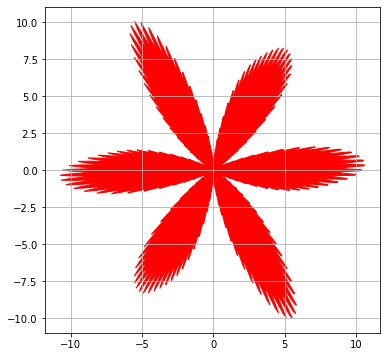

In [5]:
theta = torch.linspace(-np.pi, np.pi, steps=1000)

# compute rho(theta) as per formula above
rho = (1 + 0.9 * torch.cos(6 * theta)) * (1 + 0.01 * torch.cos(24 * theta)) * \
        (0.5 + 0.05 * torch.cos(200 * theta)) * (10 + torch.sin(10 * theta))

# # Now convert polar (rho, theta) pairs into cartesian (x,y) to plot them.
x = rho * torch.cos(theta)### YOUR CODE HERE
y = rho * torch.sin(theta)### YOUR CODE HERE


plt.figure(figsize=(6, 6))
plt.fill(x.numpy(), y.numpy(), color='red')
plt.grid()

### Task 2: Using the Dataloader

In [7]:
from torch import nn
#from torch.nn.f import functional as F
import torch.nn.functional as F

In [8]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/basic_s20/week0_09_Optimization_and_Regularization_in_DL/notmnist.py -nc

File ‘notmnist.py’ already there; not retrieving.



In [9]:
from notmnist import load_notmnist
X_train, y_train, X_test, y_test = load_notmnist()

Extracting ...
Parsing...
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [31]:
class DatasetMNIST(Dataset):
    def __init__(self, path='./notMNIST_small', letters='ABCDEFGHIJ', transform=None):
        self.data, self.labels, _ ,_  = load_notmnist(path=path, letters=letters, test_size=0)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        image = self.data[index]
        #print('before', image.shape)
        image = image.transpose(1, 2, 0)
        #print('after', image.shape)
        label = self.labels[index]

        if self.transform is not None:
            image = self.transform(image)
            #image_2 = self.transforms_2(image)

        return image, label

In [32]:
full_dataset = DatasetMNIST('./notMNIST_small', 'AB', transform=None)

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [33]:
# we can access and get data with index by __getitem__(index)
img, lab = full_dataset.__getitem__(0)

print(img.shape)
print(type(img))

(28, 28, 1)
<class 'numpy.ndarray'>


In [34]:
a = torchvision.transforms.ToTensor()

a(img).shape

torch.Size([1, 28, 28])

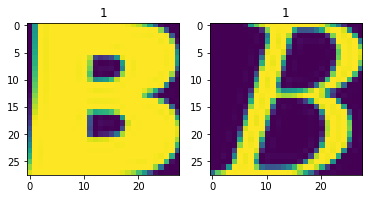

In [38]:
inds = np.random.randint(len(full_dataset), size=2)

for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(full_dataset[inds[i]][0].reshape([28,28]))
    plt.title(str(full_dataset[inds[i]][1]))

#### To the DataLoader

In [39]:
train_loader = DataLoader(full_dataset, batch_size=8, shuffle=True)

We can use dataloader as iterator by using iter() function.

In [40]:
train_iter = iter(train_loader)
print(type(train_iter))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>


We can look at images and labels of batch size by extracting data `.next()` method.

In [41]:
images, labels = train_iter.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

images shape on batch size = torch.Size([8, 28, 28, 1])
labels shape on batch size = torch.Size([8])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/amarkov/miniconda3/envs/miso/lib/python3.8/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


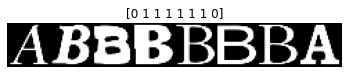

In [43]:
# make grid takes tensor as arg
# tensor : (batchsize, channels, height, width)
grid = torchvision.utils.make_grid(images.permute([0, 3, 1, 2]))

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title(labels.numpy());

And now with transformations:

In [44]:
train_dataset_with_transform = DatasetMNIST(
    transform=torchvision.transforms.ToTensor()
)

Parsing...
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [46]:
img, lab = train_dataset_with_transform.__getitem__(0)

print('image shape at the first row : {}'.format(img.size()))

image shape at the first row : torch.Size([1, 28, 28])


In [47]:
train_loader_tr = DataLoader(train_dataset_with_transform, batch_size=8, shuffle=True)

train_iter_tr = iter(train_loader_tr)
print(type(train_iter_tr))

images, labels = train_iter_tr.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([8, 1, 28, 28])
labels shape on batch size = torch.Size([8])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


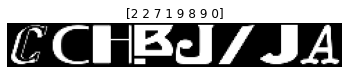

In [48]:
grid = torchvision.utils.make_grid(images)

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title(labels.numpy());

### Composing several transformations

If you want to take data augmentation, you have to make List using `torchvision.transforms.Compose`

```
class Compose(object):
    """Composes several transforms together.
    Args:
        transforms (list of ``Transform`` objects): list of transforms to compose.
    Example:
        >>> transforms.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        for t in self.transforms:
            format_string += '\n'
            format_string += '    {0}'.format(t)
        format_string += '\n)'
        return format_string
```


this function can convert some image by order within `__call__` method.

In [63]:
class Flatten():
    def __call__(self, pic):
        return pic.flatten()

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [64]:
a = Flatten()

In [65]:
a(img).shape

torch.Size([784])

In [67]:
new_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    Flatten()
])

# Putting all together

In [68]:
import time

from IPython.display import clear_output

In [71]:
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [77]:
def subset_ind(dataset, ratio: float):
#     return ### YOUR CODE HERE
    return np.random.choice(len(dataset), size=int(ratio*len(dataset)), replace=False)

In [78]:
dataset = DatasetMNIST(
    './notMNIST_small',
#     'AB',
    transform=new_transform
)

# #EX 1
# transform = transforms.Compose([
#         transforms.ToTensor(),
# ])
# trainloader = torch.utils.data.DataLoader(
#         datasets.MNIST('../data/mnist/', train=True, download=True, transform=transform),
#         batch_size=batch_size, shuffle=True)

# testloader = torch.utils.data.DataLoader(
#         datasets.MNIST('../data/mnist/', train=False, download=True, transform=transform),
#         batch_size=batch_size, shuffle=True)

shrink_inds = subset_ind(dataset, 0.2)
dataset = Subset(dataset, shrink_inds)

print(f'\n\n dataset size: {len(dataset)}, labels: {np.unique(dataset.dataset.labels)}')

Parsing...
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


 dataset size: 3744, labels: [0 1 2 3 4 5 6 7 8 9]


In [80]:
val_size = 0.2
val_inds = subset_ind(dataset, val_size)

train_dataset = Subset(dataset, [i for i in range(len(dataset)) if i not in val_inds])
val_dataset = Subset(dataset, val_inds)

print(f'  training size: {len(train_dataset)}\nvalidation size: {len(val_dataset)}')

  training size: 2996
validation size: 748


In [81]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# EX 2
# trainset = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform_train)
# trainloader = data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers)

# testset = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=transform_test)
# testloader = data.DataLoader(testset, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)


In [82]:
train_iter = iter(train_loader)
print(type(train_iter))

images, labels = train_iter.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([32, 784])
labels shape on batch size = torch.Size([32])


In [88]:
loss_func = nn.CrossEntropyLoss()
loss_func_logits = F.cross_entropy

In [85]:
#loss = loss_func(y_pred, y_true)
#F.cross_entropy(y_pred, y_true)

In [90]:
list(model.named_parameters())

[('0.weight',
  Parameter containing:
  tensor([[ 5.7073e-03,  1.4372e-02, -5.9362e-03,  ...,  1.7611e-02,
           -3.1638e-02,  1.5071e-02],
          [ 1.2011e-02, -3.0605e-02,  1.7456e-02,  ..., -1.6547e-02,
           -1.7293e-03, -1.5025e-02],
          [-3.5085e-02, -2.8424e-02,  3.3374e-02,  ...,  3.2641e-02,
            3.4933e-02,  2.6431e-02],
          ...,
          [ 3.1654e-02, -3.2889e-05,  2.4749e-02,  ..., -2.6400e-02,
            3.4983e-02,  1.1723e-02],
          [ 1.4595e-03, -7.1094e-03,  3.1450e-02,  ..., -7.4248e-04,
            1.1615e-02, -3.4893e-02],
          [ 2.6896e-02,  2.4283e-02, -1.4953e-02,  ..., -2.8074e-02,
           -9.5517e-03,  3.0577e-02]], requires_grad=True)),
 ('0.bias',
  Parameter containing:
  tensor([-0.0085, -0.0207,  0.0245,  0.0282,  0.0010, -0.0045,  0.0234,  0.0127,
          -0.0090, -0.0315], requires_grad=True))]

In [112]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(784, 10)
#    nn.Sigmoid(), # x -> 1 / (1 + e^{-x})
)
model.to(device, torch.float32)

# for p, name in model.named_parameters():
#     p.requires_grad = False
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# params = [p for name, p in model.named_parameters() if train(name) ]

In [113]:
for x, y in train_loader:
    break

In [114]:
x = x.to(device)
y = y.to(device)

out = model(x)

In [115]:
loss = loss_func(out, y)

In [116]:
p = list(model.parameters())[0]

In [120]:
p.grad

In [121]:
loss.backward()

In [122]:
p = list(model.parameters())[0]

In [124]:
p.grad.shape 

torch.Size([10, 784])

In [141]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    '''
    model: нейросеть для обучения,
    train_loader, val_loader: загрузчики данных
    loss_fn: целевая метрика (которую будем оптимизировать)
    opt: оптимизатор (обновляет веса нейросети)
    n_epochs: кол-во эпох, полных проходов датасета
    '''
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            ### YOUR CODE HERE
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            ### YOUR CODE HERE
            opt.zero_grad()
            outs = model(X_batch)
            loss = loss_func(outs, y_batch)
            
            loss.backward()
            opt.step()
            
            ep_train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                ### YOUR CODE HERE

                # compute predictions
                ### YOUR CODE HERE
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                ### YOUR CODE HERE
                outs = model(X_batch)
                pred_probs = F.softmax(outs, dim=-1)
                loss = loss_func(outs, y_batch)

                ep_val_loss.append(loss.item())
                y_pred = torch.argmax(pred_probs, dim=-1)
                acc = np.mean(y_pred.cpu().numpy() == y_batch.cpu().numpy())
                ep_val_accuracy.append(acc)
    
        
        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

In [142]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 0.466s
	  training loss: 0.011306
	validation loss: 0.910588
	validation accuracy: 0.891
Epoch 2 of 30 took 0.451s
	  training loss: 0.006273
	validation loss: 0.834602
	validation accuracy: 0.897
Epoch 3 of 30 took 0.439s
	  training loss: 0.001761
	validation loss: 0.902894
	validation accuracy: 0.885
Epoch 4 of 30 took 0.439s
	  training loss: 0.002415
	validation loss: 0.849695
	validation accuracy: 0.893
Epoch 5 of 30 took 0.434s
	  training loss: 0.002362
	validation loss: 0.877361
	validation accuracy: 0.899
Epoch 6 of 30 took 0.441s
	  training loss: 0.001791
	validation loss: 0.897013
	validation accuracy: 0.903
Epoch 7 of 30 took 0.445s
	  training loss: 0.001534
	validation loss: 0.856783
	validation accuracy: 0.899
Epoch 8 of 30 took 0.430s
	  training loss: 0.001358
	validation loss: 0.856804
	validation accuracy: 0.905
Epoch 9 of 30 took 0.445s
	  training loss: 0.001239
	validation loss: 0.871266
	validation accuracy: 0.902
Epoch 10 of 30 took 0.457s
	

In [143]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

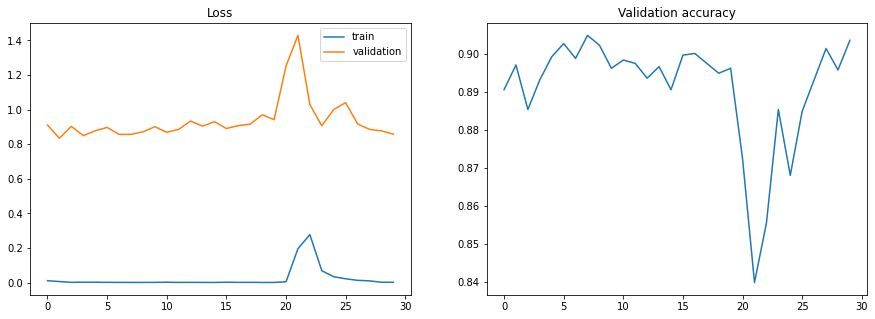

In [145]:
plot_train_process(train_loss, val_loss, val_accuracy)

## Real network

In [146]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(784, 500),
    nn.ReLU(),
    nn.Linear(500, 200),
    nn.ReLU(),
#     nn.Dropout(p=0.3),
#     nn.BatchNorm1d(200),
    nn.Linear(200, 10),
    #nn.Sigmoid(),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [147]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 0.449s
	  training loss: 0.684440
	validation loss: 0.492508
	validation accuracy: 0.859
Epoch 2 of 30 took 0.424s
	  training loss: 0.332744
	validation loss: 0.463330
	validation accuracy: 0.865
Epoch 3 of 30 took 0.447s
	  training loss: 0.252316
	validation loss: 0.430755
	validation accuracy: 0.884
Epoch 4 of 30 took 0.462s
	  training loss: 0.159583
	validation loss: 0.445507
	validation accuracy: 0.885
Epoch 5 of 30 took 0.445s
	  training loss: 0.115900
	validation loss: 0.547421
	validation accuracy: 0.869
Epoch 6 of 30 took 0.434s
	  training loss: 0.093864
	validation loss: 0.593663
	validation accuracy: 0.880
Epoch 7 of 30 took 0.418s
	  training loss: 0.083661
	validation loss: 0.592889
	validation accuracy: 0.877
Epoch 8 of 30 took 0.439s
	  training loss: 0.061920
	validation loss: 0.599082
	validation accuracy: 0.882
Epoch 9 of 30 took 0.442s
	  training loss: 0.086319
	validation loss: 0.721171
	validation accuracy: 0.870
Epoch 10 of 30 took 0.444s
	

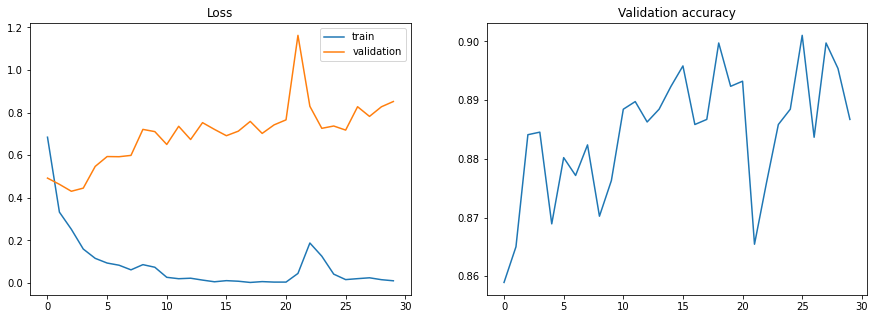

In [148]:
plot_train_process(train_loss, val_loss, val_accuracy)

## Your turn
Try to add some additional transformations (e.g. random crop, rotation etc.) and train your model!

### Dropout try

### Batchnorm try

### 3. Save the model (model checkpointing)

Now we have trained a model! Obviously we do not want to retrain the model everytime we want to use it. Plus if you are training a super big model, you probably want to save checkpoint periodically so that you can always fall back to the last checkpoint in case something bad happened or you simply want to test models at different training iterations.

Model checkpointing is fairly simple in PyTorch. First, we define a helper function that can save a model to the disk

In [ ]:
def save_checkpoint(checkpoint_path, model, optimizer):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

In [ ]:
# create a brand new model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Testing -- you should get a pretty poor performance since the model hasn't learned anything yet.
test()

#### Define a training loop with model checkpointing

In [ ]:
def train_save(epoch, save_interval, log_interval=100):
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            # different from before: saving model checkpoints
            if iteration % save_interval == 0 and iteration > 0:
                save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)
            iteration += 1
        test()
    
    # save the final model
    save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)

In [ ]:
train_save(5, save_interval=500, log_interval=100)

In [ ]:
# create a new model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# load from the final checkpoint
load_checkpoint('mnist-4690.pth', model, optimizer)
# should give you the final model accuracy
test()

```

```

```

```

```

```

```

```

```

```
### More about pytorch:
* Using torch on GPU and multi-GPU - [link](http://pytorch.org/docs/master/notes/cuda.html)
* More tutorials on pytorch - [link](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
* Pytorch examples - a repo that implements many cool DL models in pytorch - [link](https://github.com/pytorch/examples)
* Practical pytorch - a repo that implements some... other cool DL models... yes, in pytorch - [link](https://github.com/spro/practical-pytorch)
* And some more - [link](https://www.reddit.com/r/pytorch/comments/6z0yeo/pytorch_and_pytorch_tricks_for_kaggle/)

In [2]:
import numpy as np

array([[0, 1, 0, 1, 1, 0, 1, 0, 1, 1],
       [0, 0, 0, 0, 1, 0, 1, 1, 0, 0],
       [0, 0, 0, 1, 0, 1, 1, 1, 1, 0],
       [1, 1, 0, 0, 1, 0, 1, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 1, 0, 1, 1],
       [1, 0, 1, 1, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 1, 0, 1, 0],
       [1, 1, 0, 1, 0, 1, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
       [1, 1, 0, 1, 0, 1, 1, 1, 0, 1]])

In [53]:
verts_as_matrix

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [55]:
verts_as_matrix.shape

(10, 10)

In [56]:
mask.shape

(10, 10, 1)

In [116]:
verts_projected = np.random.randint(0, 10, (15, 50, 2))

In [126]:
batch_element = np.arange(len(verts_projected))

In [134]:
np.repeat(np.arange(3), 3)

array([0, 0, 0, 1, 1, 1, 2, 2, 2])

In [132]:
new_verts_projected = np.concatenate([verts_projected, np.arange(verts_projected.shape[0])[:, None]])

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)

In [140]:
a = np.reshape(verts_projected, (-1, 2))
b = np.repeat(np.arange(verts_projected.shape[0]), verts_projected.shape[1])[:, None]

In [141]:
a.shape

(750, 2)

In [142]:
b.shape

(750, 1)

In [145]:
verts_projected = np.random.randint(0, 10, (15, 50, 2))
new_verts_projected = np.hstack([
    np.repeat(np.arange(verts_projected.shape[0]), verts_projected.shape[1])[:, None],
    np.reshape(verts_projected, (-1, 2))
])

In [146]:
new_verts_projected

array([[ 0,  9,  4],
       [ 0,  1,  7],
       [ 0,  0,  6],
       ...,
       [14,  9,  9],
       [14,  7,  7],
       [14,  9,  9]])

In [130]:
new_verts_projected.shape

(750, 2)

In [149]:
import torch

In [178]:
mask = np.random.randint(0, 2, (15, 1, 10, 10)).astype(bool)
mask[..., -1]

verts_projected = np.random.randint(0, 10, (15, 50, 2))
new_verts_projected = np.hstack([
    np.repeat(np.arange(verts_projected.shape[0]), verts_projected.shape[1])[:, None],
    np.reshape(verts_projected, (-1, 2))
])

verts_as_matrix = np.zeros_like(mask[:, -1, :, :])
verts_as_matrix[verts_projected[:, 0], verts_projected[:, 1], verts_projected[:, 2]] = True
c = verts_as_matrix * ~mask[:, -1, :, :]

indices = np.where(c)


images1 = np.random.randint(0, 256, (15, 3, 10, 10))
images2 = np.random.randint(0, 256, (15, 3, 10, 10))

images2[indices, :] = images1[indices, :]

In [179]:
torch.repeat_interleave(torch.arange(10), 15)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9])

In [180]:
mask = torch.from_numpy(mask).type(torch.BoolTensor)
images1 = torch.from_numpy(images1)
images2 = torch.from_numpy(images2)
verts_projected = torch.from_numpy(verts_projected)



In [198]:
mask = np.random.randint(0, 2, (15, 1, 10, 10)).astype(bool)
mask[..., -1]

verts_projected = np.random.randint(0, 10, (15, 50, 2))
new_verts_projected = np.hstack([
    np.repeat(np.arange(verts_projected.shape[0]), verts_projected.shape[1])[:, None],
    np.reshape(verts_projected, (-1, 2))
])

verts_as_matrix = np.zeros_like(mask[:, -1, :, :])
verts_as_matrix[new_verts_projected[:, 0], new_verts_projected[:, 1], new_verts_projected[:, 2]] = True
c = verts_as_matrix * ~mask[:, -1, :, :]

indices = np.where(c)


images1 = np.random.randint(0, 256, (15, 3, 10, 10))
images2 = np.random.randint(0, 256, (15, 3, 10, 10))

images2[indices, :] = images1[indices, :]


mask = torch.from_numpy(mask).type(torch.BoolTensor)
images1 = torch.from_numpy(images1)
images2 = torch.from_numpy(images2)
verts_projected = torch.from_numpy(verts_projected)





new_verts_projected = torch.cat(
    [
        torch.repeat_interleave(torch.arange(verts_projected.shape[0]), verts_projected.shape[1])[:, None],
        verts_projected.view((-1, 2))
    ],
    dim=1
)
verts_as_matrix = torch.zeros_like(mask[:, -1, :, :])
verts_as_matrix[new_verts_projected[:, 0], new_verts_projected[:, 1], new_verts_projected[:, 2]] = True
c = verts_as_matrix * ~mask[:, -1, :, :]

indices = torch.where(c)

images2[indices[0], :, indices[1], indices[2]] = images1[indices[0], :, indices[1], indices[2]]

In [208]:
mask.shape

torch.Size([15, 1, 10, 10])

In [207]:
verts_as_matrix.shape

torch.Size([15, 10, 10])

In [217]:
np.where(verts_as_matrix * ~mask[:, 0])

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
         9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 

In [211]:
mask[0, 0]

tensor([[False, False,  True, False, False, False,  True, False,  True,  True],
        [ True,  True, False, False,  True, False, False, False,  True, False],
        [False,  True,  True, False,  True,  True,  True,  True, False,  True],
        [ True, False,  True,  True,  True, False,  True, False, False, False],
        [ True,  True,  True,  True, False, False,  True,  True,  True, False],
        [False, False, False, False, False, False,  True, False, False, False],
        [False,  True, False,  True,  True,  True,  True, False, False, False],
        [ True, False, False,  True, False, False, False,  True,  True,  True],
        [ True,  True, False, False,  True,  True, False,  True,  True, False],
        [False,  True,  True,  True,  True,  True, False, False, False, False]])

In [209]:
torch.where((verts_as_matrix[:, None, :, :] * ~mask))

(tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
          4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
          5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
          5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,
          7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
          8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,
          9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10,
         10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11,
         11, 11, 11, 11, 11,

In [191]:
torch.equal(images2[indices[0], :, indices[1], indices[2]], images1[indices[0], :, indices[1], indices[2]])

True

In [194]:
verts_projected.shape

torch.Size([15, 50, 2])

In [197]:
i = 0
xs = []
ys = []
for x, y in verts_projected[i]:
    if mask[i, int(x), int(y)] == False:
        xs.append(x)
        ys.append(y)

IndexError: index 7 is out of bounds for dimension 1 with size 1

In [184]:
torch.where(c)

(tensor([0, 0, 1, 2, 2, 3, 4, 4, 4, 5, 6, 7, 8, 8, 9]),
 tensor([0, 5, 6, 3, 9, 0, 1, 4, 5, 8, 9, 6, 1, 7, 2]),
 tensor([2, 4, 6, 4, 6, 7, 6, 6, 0, 0, 2, 5, 3, 5, 0]))

In [ ]:
ima

In [70]:
from matplotlib import pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


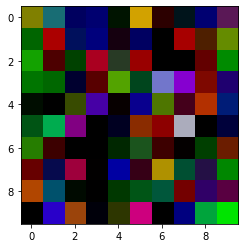

In [77]:
plt.imshow(images1[0] - images2[0])

In [58]:
c.shape

(10, 10)

(array([0, 1, 1, 2, 3, 3, 3, 5, 5, 6, 7, 7, 7, 8, 8, 8, 9, 9]),
 array([3, 4, 7, 3, 1, 4, 8, 2, 3, 6, 0, 1, 5, 1, 4, 6, 0, 7]))

In [42]:
c[0, 8]

1.0

In [95]:
[''.join(str(x)) for x in zip([1,2,3], [4,5,6])]

['(1, 4)', '(2, 5)', '(3, 6)']

In [92]:
list(zip([1,2,3], [4,5,6]))

[(1, 4), (2, 5), (3, 6)]

In [90]:
''.join(zip([1,2,3], [4,5,6]))

TypeError: sequence item 0: expected str instance, tuple found

In [112]:
class Solution:
    def numUniqueEmails(self, emails) -> int:
        splitted = [_email.split('@') for _email in emails]
        print(splitted)
        basenames = [x[0] for x in splitted]
        basenames = [x.split('+')[0].replace('.', '') for x in basenames]
        print(basenames)
        print(list(zip(basenames, [x[1] for x in splitted])))
        final_list = set(['@'.join(x) for x in zip(basenames, [x[1] for x in splitted])])
        return final_list, len(set(final_list))

In [113]:
solution = Solution()

In [114]:
solution.numUniqueEmails(["test.email+alex@leetcode.com", "test.email@leetcode.com"])

[['test.email+alex', 'leetcode.com'], ['test.email', 'leetcode.com']]
['testemail', 'testemail']
[('testemail', 'leetcode.com'), ('testemail', 'leetcode.com')]


({'testemail@leetcode.com'}, 1)

In [226]:
a = dict()
a.setdefault(1, set())

set()

In [227]:
a.setdefault(1, set()).add(3)

In [228]:
a

{1: {3}}

In [229]:
a.setdefault(1, set()).add(3)

In [230]:
a

{1: {3}}

In [231]:
a.setdefault(1, set()).add(5)

In [232]:
a

{1: {3, 5}}

In [ ]:
class Solution:
    def ladderLength(self, beginWord: str, endWord: str, wordList: List[str]) -> int:
        wordLen = len(wordList[0])
        pr_dict = {}
        inv_pr_dict = {}
        for word in wordList:
            for i in range(wordLen):
                local_word = list(word)
                local_word[i] = '*'
                pr_dict.setdefault(''.join(local_word), set()).add(word)
        return pr_dict
    
        queue = [(beginWord, 1)]
        visited_dict = {}